In [2]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import random
from jax import grad, jit, vmap
from jax.scipy.special import logsumexp


### 定数

* $\gamma \in [0, 1]$ : 割引係数

### 変数

* $\mathcal{M}$: マルコフ決定過程 (MDP)
* $\mathcal{S}$: 状態空間
* $\mathcal{A}$: 行動空間
* $R(s, a) \in [0, 1]$: 状態 $s$ で行動 $a$ を取った時の報酬
* $T(s' | s, a)$: 状態 $s$ で行動 $a$ を取った時に状態 $s'$ へ遷移する確率
* $\pi(a | s)$: 状態 $s$ における方策（行動 $a$ を選択する確率）
* $\hat{\mathcal{M}}$: 近似的な MDP
* $\hat{R}(s, a)$: 近似的な MDP における報酬
* $\hat{T}(s' | s, a)$: 近似的な MDP における遷移確率
* $\epsilon_T$: 遷移確率の誤差の上限
* $\epsilon_R$: 報酬の誤差の上限
* $P^\pi$: 方策 $\pi$ に基づく状態遷移確率行列
* $\hat{P}^\pi$: 近似的な MDP における方策 $\pi$ に基づく状態遷移確率行列
* $R^\pi$: 方策 $\pi$ に基づく状態ごとの期待報酬ベクトル
* $\hat{R}^\pi$: 近似的な MDP における方策 $\pi$ に基づく状態ごとの期待報酬ベクトル
* $V^\pi$: 方策 $\pi$ の価値関数 (ベクトル)
* $\hat{V}^\pi$: 近似的な MDP における方策 $\pi$ の価値関数 (ベクトル)
* $v^\pi(s)$: 状態 $s$ における方策 $\pi$ の価値
* $s_t$: 時刻 $t$ における状態
* $s_0$: 初期状態
* $\pi^*$: 最適方策
* $\hat{\pi}^*$: 近似的な MDP における最適方策
* $H$: 有限 horizon の長さ
* $V_{h, s}^\pi$:  時刻 $h$、状態 $s$ における方策 $\pi$ の価値
* $\hat{V}_{h, s}^\pi$: 近似的な MDP における時刻 $h$、状態 $s$ における方策 $\pi$ の価値

* $R_{MAX}$: 最大報酬

### 関数

* $\|\cdot\|_1$: $L_1$ ノルム
* $\|\cdot\|_\infty$: $L_\infty$ ノルム
* $\langle \cdot, \cdot \rangle$: 内積
* $\min(\cdot, \cdot)$: 最小値
* $[\cdot]^+$: 非負部分のみを保持する関数 (ex. $[x]^+ = \max(x, 0)$)




### An Optimal Tightness Bound for the Simulation Lemma
https://arxiv.org/abs/2406.16249


割引無限MDP$\mathcal{M}=(\mathcal{S}, \mathcal{A}, R, T, \gamma)$を考えます。

* $\mathcal{S}$:状態空間
* $\mathcal{A}$:行動空間
* $\gamma \in[0,1]$ : 割引率
* $T\left(s^{\prime} \mid s, a\right)$ : 状態遷移確率
* $R(s, a) \in[0,1]$ : 報酬関数
* $\pi(a \mid s)$ : 方策

シミュレーション補題は2つの異なるMDPで同じ方策を実行したときのそれぞれのMDPの$V$の差をバウンドすることを目的としています。

$R$と$T$のみが異なるMDP $\hat{\mathcal{M}}=(\mathcal{S}, \mathcal{A}, \hat{R}, \hat{T}, \gamma)$ を定義すると、


**シミュレーション補題**

$$
\forall s, \pi:\left|V_{s}^{\pi}-\hat{V}_{s}^{\pi}\right| \leq \epsilon_{R}+\frac{\gamma \epsilon_{T}}{2(1-\gamma)}+\gamma\left\|V^{\pi}-\hat{V}^{\pi}\right\|_{\infty}
$$

が成立します。なお、$\hat{V}^{\pi}$は$\hat{\mathcal{M}}$における状態価値関数です。


**何が問題か？**

再帰的に考えると、第3項は**次状態での状態価値推定誤差の最大値**となるのでシミュレーション補題の右辺側を次状態に関してもう一度考えることになります。そうすると次状態での誤差がどんどん上界を示す式に蓄積されていきます。その中でも、2番目の項($\frac{\gamma \epsilon_{T}}{2(1-\gamma)}$)が問題です。これは遷移確率の推定誤差であり、再帰的に考える(未来のステップも考える)と、すべてのステップで$\epsilon_{T}$の誤差が発生すると仮定されているわけです。これにより、上界がかなり高く評価(過大評価)されてしまう問題が発生してしまいます。



**問題に対するアプローチ**

上界が過大評価されるのを防ぐために、$\epsilon_{T}$を導出した
$$
\begin{aligned}
\forall s, \pi:\left\|P_{s}^{\pi}-\hat{P}_{s}^{\pi}\right\|_{1} & \leq \epsilon_{T} \\
\end{aligned}
$$
における確率分布の距離の測り方を**オーバーラップ**という考えつかいます。オーバーラップとは
$$
\bar{p}_{i}=\min \left(p_{i}, \hat{p}_{i}\right)
$$
を意味します。これを用いると遷移確率誤差をいい感じにバウンドできます。今回の問題に適用すると、タイムステップ間での遷移確率推定誤差(オーバーラップ)の下界をだすことができます。これにより、$\epsilon_{T}$がひたすらに蓄積していかない形ではなく、減衰していく形で状態価値推定誤差の上界の項を書き直すことができます。

$$
\bar{M}_{s_{0}, s}^{t}=\min \left(P_{s_{0}, s}^{t}, \hat{P}_{s_{0}, s}^{t}\right)
$$
とすると、

$$
\begin{aligned}
\left\|\bar{M}_{s_{0}}^{t+1}\right\|_{1} & =\sum_{s^{\prime}} \min \left(P_{s_{0}, s^{\prime}}^{t+1}, \hat{P}_{s_{0}, s^{\prime}}^{t+1}\right) \\
& =\sum_{s^{\prime}} \min \left(\sum_{s} P_{s_{0}, s}^{t} \cdot P_{s, s^{\prime}}^{\pi}, \sum_{s} \hat{P}_{s_{0}, s}^{t} \cdot \hat{P}_{s, s^{\prime}}^{\pi}\right) \\
& \geq \sum_{s^{\prime}}^{\pi} \sum_{s} \min \left(P_{s_{0}, s}^{t} \cdot P_{s, s^{\prime}}^{\pi}, \hat{P}_{s_{0}, s}^{t} \cdot \hat{P}_{s, s^{\prime}}^{\pi}\right) \\
& \left.\geq \sum_{s^{\prime}} \sum_{s} \min \left(\min \left(P_{s_{0}, s}^{t}, \hat{P}_{s_{0}, s}^{t}\right) \cdot P_{s, s^{\prime}}^{\pi}\right), \min \left(P_{s_{0}, s}^{t}, \hat{P}_{s_{0}, s}^{t}\right) \cdot \hat{P}_{s, s^{\prime}}^{\pi}\right) \\
& =\sum_{s} \sum_{s^{\prime}} \min \left(P_{s_{0}, s}^{t}, \hat{P}_{s_{0}, s}^{t}\right) \min \left(P_{s, s^{\prime}}^{\pi}, \hat{P}_{s, s^{\prime}}^{\pi}\right) \\
& =\sum_{s}^{\pi} \min \left(P_{s_{0}, s}^{t}, \hat{P}_{s_{0}, s}^{t}\right) \sum_{s^{\prime}} \min \left(P_{s, s^{\prime}}^{\pi}, \hat{P}_{s, s^{\prime}}^{\pi}\right) \\
& \geq\left\|\bar{M}_{s_{0}}^{t}\right\|_{1} \cdot \max \left\|\bar{P}_{s}^{\pi}\right\|_{1} \\
\Longrightarrow\left\|\bar{M}_{s_{0}}^{t+1}\right\|_{1} & \geq\left\|\bar{M}_{s_{0}}^{t}\right\|_{1} \cdot\left(1-\epsilon_{T} / 2\right) .
\end{aligned}
$$

これにより、少なくとも、次のタイムステップでのオーバーラップのL1ノルムは、現在のL1ノルムを$1-\epsilon_{T} / 2$倍したものであるといえます。一方で既存の方法では、ホライゾンが無限大に近づくにつれて$\epsilon_{T}$が際限なく蓄積されます。

$$
\begin{aligned}
\left\|P_{s_{0}}^{t+1}-\hat{P}_{s_{0}}^{t+1}\right\|_{1} & =\left\|P_{s_{0}}^{t} P^{\pi}-\hat{P}_{s_{0}}^{t} \hat{P}^{\pi}\right\|_{1} \\
& =\frac{1}{2}\left\|\left(P_{s_{0}}^{t}-\hat{P}_{s_{0}}^{t}\right)\left(P^{\pi}+\hat{P}^{\pi}\right)+\left(P_{s_{0}}^{t}+\hat{P}_{s_{0}}^{t}\right)\left(P^{\pi}-\hat{P}^{\pi}\right)\right\|_{1} \\
& \leq \frac{1}{2}\left\|P_{s_{0}}^{t}-\hat{P}_{s_{0}}^{t}\right\|_{1}\left\|\left(P^{\pi}+\hat{P}^{\pi}\right)^{T}\right\|_{1}+\frac{1}{2}\left\|P_{s_{0}}^{t}+\hat{P}_{s_{0}}^{t}\right\|_{1}\left\|\left(P^{\pi}-\hat{P}^{\pi}\right)^{T}\right\|_{1} \\
& =\left\|P_{s_{0}}^{t}-\hat{P}_{s_{0}}^{t}\right\|_{1}+\left\|P^{\pi}-\hat{P}^{\pi}\right\|_{1} \\
& \leq\left\|P_{s_{0}}^{t}-\hat{P}_{s_{0}}^{t}\right\|_{1}+\epsilon_{T} \\
\Longrightarrow\left\|P_{s_{0}}^{t+1}-\hat{P}_{s_{0}}^{t+1}\right\|_{1} & \leq(t+1) \epsilon_{T}
\end{aligned}
$$

次のタイムステップでの遷移確率予測誤差の上界はタイムステップ$+1$回$\epsilon_{T}$をかけたものになります。非常にでかい上界になりますね。



**新しく提案されたシミュレーション補題**

オーバーラップを活用すると以下のようなタイトな上界を示すことができます。

$$
\forall s, \pi: \quad\left|V_{s}^{\pi}-\hat{V}_{s}^{\pi}\right| \leq \frac{1}{1-\gamma}-\frac{1-\epsilon_{R}}{1-\gamma\left(1-\epsilon_{T} / 2\right)}
$$


**コラム**

* なぜ$V$の推定誤差に関するバウンドを考えるのか？

    強化学習における目的が、$V(s)^\pi$を最大にする$\pi$を求めることだからです。




#### 実装してバウンドを確認してみよう

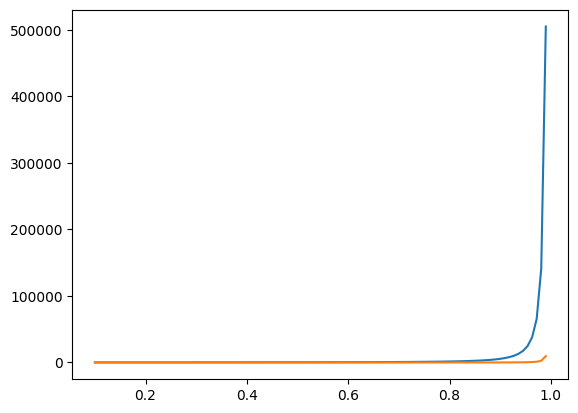

In [43]:

#gammasを100個の等間隔な値にする
gammas = np.linspace(0.1, 0.99, 100)
upperbounds = np.zeros(100)
upperbounds_proposal = np.zeros(100)
epsilon_T = 0.1
epsilon_R = 0.1
infinit_norm_of_next_state_V = 0.001

for i in range(100):
    upperbounds[i] = 1000 * (epsilon_R + (gammas[i] * epsilon_T)/(2* (1 - gammas[i])) + infinit_norm_of_next_state_V)
    upperbounds[i] = upperbounds[i] /(1 - gammas[i])

## 横軸にgamma, 縦軸にupperboundをとるグラフを描く
import matplotlib.pyplot as plt
plt.plot(gammas, upperbounds)

for i in range(100):
    upperbounds_proposal[i] = 1 / (1 - gammas[i])   - (1 -epsilon_R)/(1 - gammas[i]*(1 - epsilon_T))   * 0.5
    upperbounds_proposal[i] = upperbounds_proposal[i]  /(1 - gammas[i])

## 横軸にgamma, 縦軸にupperboundをとるグラフを描く
plt.plot(gammas, upperbounds_proposal)


